# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jan 26 16:40:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
!pip install bert-extractive-summarizer

In [4]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.2 MB/s eta 0:00:00


## importowanie datesetu

In [68]:
from datasets import load_dataset


ds = load_dataset("xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

Using the latest cached version of the dataset since xsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/xsum/default/0.0.0/7d4d486c2f8ef850b1a11aead99b894ff3dd7da9 (last modified on Mon Jan 26 16:41:54 2026).


Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [69]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [ ]:
from summarizer import Summarizer
model = Summarizer()

In [8]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [70]:
num_workers = 1
batch_size = 3

In [71]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(10))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 10
})


In [73]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [86]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ]):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [11]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [12]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [87]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [16]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [ ]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



In [45]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text:"
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    return prompt


In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer3 = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
tokenizer3.padding_side = 'left'
if tokenizer3.pad_token is None:
    tokenizer3.pad_token = tokenizer3.eos_token
    # Some models also require explicitly setting the pad_token_id
    tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3 = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")




config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [ ]:
prompt3 = generate_prompt(tokenizer3, 0)
data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: A selection of your pictures of Scotland sent in between 6 and 13 January. Send your photos to scotl
Prediction: BBC Scotland's pictures of Scotland are on display at the Museum of Scotland in Edinburgh from 23 January. You can still send in your pictures, using the form in the right.

Summarize this text: The 50-year-old was
Target: All pictures are copyrighted.
[['bbc', 'scotland', 's', 'pictures', 'of', 'scotland', 'are', 'on', 'display', 'at', 'the', 'museum', 'of', 'scotland', 'in', 'edinburgh', 'from', '23', 'january', 'you', 'can', 'still', 'send', 'in', 'your', 'pictures', 'using', 'the', 'form', 'in', 'the', 'right', 'summarize', 'this', 'text', 'the', '50', 'year', 'old', 'was'], ['the', 'tata', 'steel', 'group', 'has', 'appointed', 'an', 'interim', 'chief', 'executive', 'after', 'chief', 'executive', 'karl', 'koehler', 'stepped', 'down', 'mr', 'koehler', 'was', 'named', 'chief', 'executive', 'in', '2014', 'after', 'the', 'company', 'was', 'hit', 'by', 'a', 'series', 'of

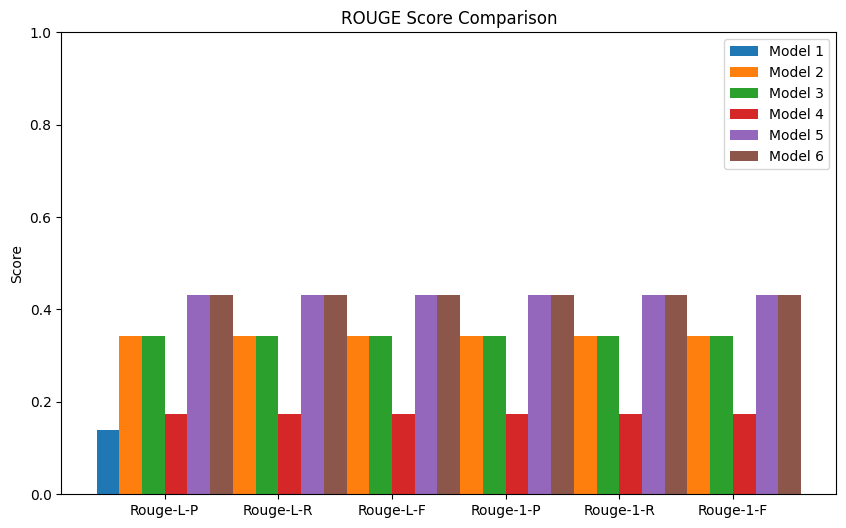

In [75]:
plot_data(data)

In [ ]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


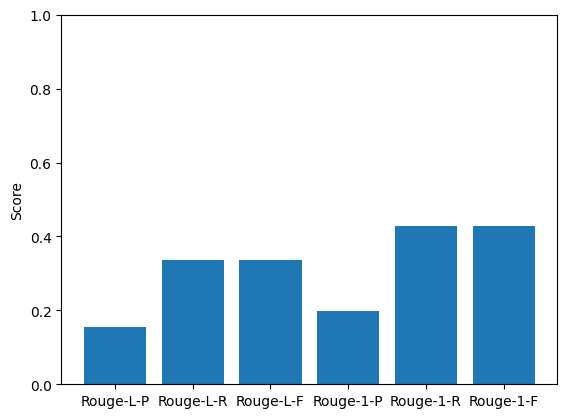

In [51]:
plot_data(data_zero_shot)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path)


In [ ]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text: [TEXT]", promptsuff = "[AGENT]")

In [ ]:
plot_data([data_ft, data, data_zero_shot])
print(data_zero_shot)
print(data_ft)